*Luis Antonio Ortega Andrés  
Antonio Coín Castro*

# Approximation of the kernel matrix

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the quality of the approximation to the kernel matrix using random features of different types (RBF, Matérn) and Nyström features.

Note that even the best results for classification need not be obtained by the method that gives the best approximation to the kernel matrix. The reason is that the approximation can have a regularization effect that may improve the accuracy of the predictions on the test set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import rbf_kernel
from sklearn import datasets
from sklearn.kernel_approximation import RBFSampler
from sklearn.gaussian_process.kernels import Matern

import kernel_approximation as ka

%load_ext autoreload
%autoreload 2

## Generate dataset

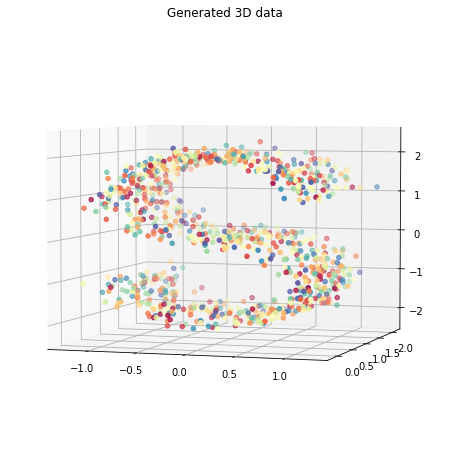

In [2]:
# Generate 3D data
n_instances = 1000
X, color = datasets.make_s_curve(n_instances, noise=0.1)
X = X[np.argsort(color)]

# Visualize dataset
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
ax.set_title("Generated 3D data")
plt.show()

## Random features with RBF kernel

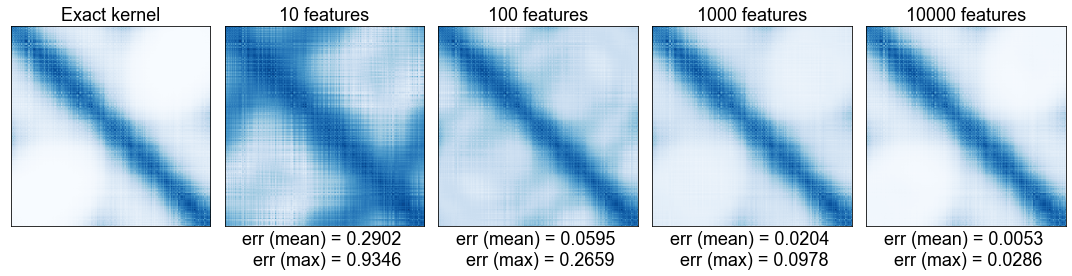

In [3]:
# RBF kernel parameters
sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


# Create an instance of the random features object
rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)

# Plot the approximation to the kernel matrix

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    rbf_sampler,
    n_random_features
)

## Random features with Matérn kernel

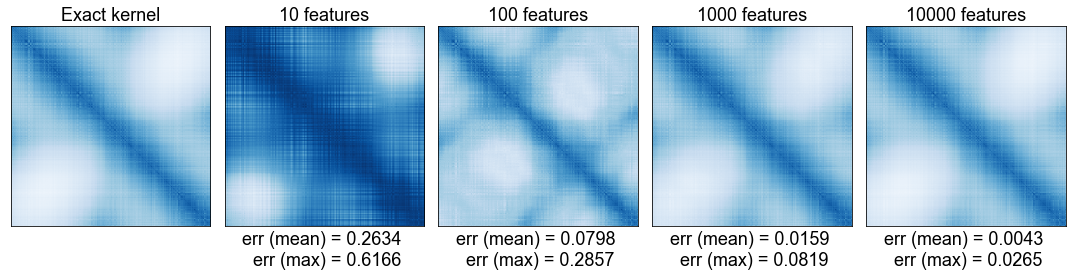

In [4]:
# Matérn kernel parameters
length_scale = 3.0
nu = 0.5

# Kernel function
kernel_matern = Matern(length_scale=length_scale, nu=nu)

def kernel(X, Y):
    return kernel_matern(X, Y)


# Create an instance of the random features object
matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)

# Plot the approximation to the kernel matrix

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    matern_sampler,
    n_random_features
)

## Nyström features with RBF kernel

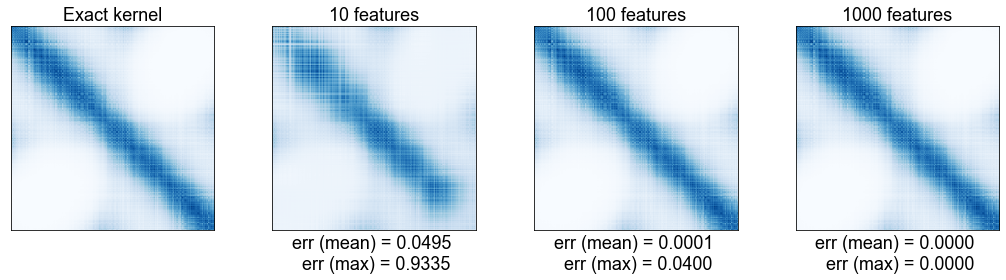

In [5]:
# Kernel parameters
sigma = 1.0
gamma = 1.0/(2.0*sigma**2)

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


# Create an instance of the Nyström features object
nystroem_sampler = ka.NystroemFeaturesSampler(kernel)

# Plot the approximation to the kernel matrix

n_nystroem_features = [10, 100, 1000]

ka.demo_kernel_approximation_features(
    X,
    kernel,
    nystroem_sampler,
    n_nystroem_features
)

### Approximation of unseen points

We compute an approximation of the kernel matrix $k(X_{test}, X)$ using the fitted Nyström features from the data matrix $X$. Specifically, we have:

$$\hat k (X_{test}, X)=\Phi(X_{test})\Phi(X)^T=(k(X_{test}, X_J)(W^{+})^{1/2})((W^{+})^{1/2}k(X_J,X)),$$

where $X_J$ is the subset of $X$ that contains only the $J$ randomly sampled columns.

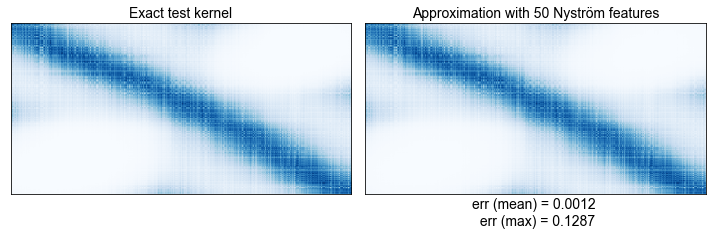

In [9]:
# Generate test data
n_instances = 500
Xt, color_t = datasets.make_s_curve(n_instances, noise=0.05)
Xt = Xt[np.argsort(color_t)]

# Compute genuine kernel (test) matrix
Kt = kernel(Xt, X)

# Compute kernel (test) matrix approximation
n_features = 50
X_features = nystroem_sampler.fit_transform(n_features, X)
Xt_features = nystroem_sampler.transform(Xt)
Kt_hat = Xt_features@X_features.T

# Set plot options
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 7)
font = {'fontname': 'arial', 'fontsize': 14}

# Plot original kernel
kernel_matrix = kernel(X, X)
axes[0].imshow(Kt, cmap=plt.cm.Blues)
axes[0].set_title('Exact test kernel', **font)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot approximated kernel and print absolute errors
axes[1].imshow(Kt_hat, cmap=plt.cm.Blues)
axes[1].set_title(
    'Approximation with {} Nyström features'.format(
        n_features
    ), **font)
axes[1].set_xticks([])
axes[1].set_yticks([])
err_approx = Kt - Kt_hat
err_mean = np.mean(np.abs(err_approx))
err_max = np.max(np.abs(err_approx))
axes[1].set_xlabel(
    'err (mean) = {:.4f} \n err (max) = {:.4f}'.format(
        err_mean,
        err_max
    ), **font)

plt.tight_layout()
plt.show()